**Update to Diana's 'ingest_preprocess_era-5.ipynb' used only for precip v1.1**

In [1]:
%matplotlib inline

import gcsfs
import fsspec
import xarray as xr
import numpy as np
import os 

import intake 
from datetime import datetime
import pandas as pd
from pathlib import Path, PurePath

import dask
import dask.array as dda
import dask.distributed as dd

# rhodium-specific kubernetes cluster configuration
import rhg_compute_tools.kubernetes as rhgk

In [2]:
client, cluster = rhgk.get_big_cluster()
cluster.scale(30)

In [3]:
client

Client Scheduler: gateway://traefik-impactlab-hub-dask-gateway.impactlab-hub:80/impactlab-hub.636756259a294b76aae63e4251e0074f Dashboard: /services/dask-gateway/clusters/impactlab-hub.636756259a294b76aae63e4251e0074f/status,Cluster Workers: 1 Cores: 1 Memory: 24.16 GB


In [74]:
cluster.close()

In [4]:
with xr.open_zarr(fsspec.get_mapper('gcs://pangeo-era5/reanalysis/spatial-analysis'),
                  consolidated=True,
                  chunks='auto') as ds:
    print("accessing hourly ERA-5 data lazily from a google cloud bucket using fsspec")

accessing hourly ERA-5 data lazily from a google cloud bucket using fsspec


In [5]:
ds

<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440, time: 350640)
Coordinates:
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time       (time) datetime64[ns] 1979-01-01 ... 2018-12-31T23:00:00
Data variables:
    asn        (time, latitude, longitude) float32 dask.array<chunksize=(31, 721, 1440), meta=np.ndarray>
    d2m        (time, latitude, longitude) float32 dask.array<chunksize=(31, 721, 1440), meta=np.ndarray>
    e          (time, latitude, longitude) float32 dask.array<chunksize=(31, 721, 1440), meta=np.ndarray>
    mn2t       (time, latitude, longitude) float32 dask.array<chunksize=(31, 721, 1440), meta=np.ndarray>
    mx2t       (time, latitude, longitude) float32 dask.array<chunksize=(31, 721, 1440), meta=np.ndarray>
    ptype      (time, latitude, longitude) float32 dask.array<chunksize=(31, 721, 1440), meta=np.ndarray>
    ro         (time, latitude, longitude) float32 dask.array<chunksize=(31, 721, 1440), meta=np.ndarray>
    sd         (time, latitude, longitude) float32 dask.array<chunksize=(31, 721, 1440), meta=np.ndarray>
    sro        (time, latitude, longitude) float32 dask.array<chunksize=(31, 721, 1440), meta=np.ndarray>
    ssr        (time, latitude, longitude) float32 dask.array<chunksize=(31, 721, 1440), meta=np.ndarray>
    t2m        (time, latitude, longitude) float32 dask.array<chunksize=(31, 721, 1440), meta=np.ndarray>
    tcc        (time, latitude, longitude) float32 dask.array<chunksize=(31, 721, 1440), meta=np.ndarray>
    tcrw       (time, latitude, longitude) float32 dask.array<chunksize=(31, 721, 1440), meta=np.ndarray>
    tp         (time, latitude, longitude) float32 dask.array<chunksize=(31, 721, 1440), meta=np.ndarray>
    tsn        (time, latitude, longitude) float32 dask.array<chunksize=(31, 721, 1440), meta=np.ndarray>
    u10        (time, latitude, longitude) float32 dask.array<chunksize=(31, 721, 1440), meta=np.ndarray>
    v10        (time, latitude, longitude) float32 dask.array<chunksize=(31, 721, 1440), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2019-09-20 05:15:01 GMT by grib_to_netcdf-2.10.0: /opt/ecmw...

In [4]:
## Doesn't work on this workflow

#cat_url = 'https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/master.yaml'
#cat = intake.Catalog(cat_url)
#with cat.atmosphere.era5_hourly_reanalysis_single_levels_sa.to_dask() as ds:
#    print("accessing hourly ERA-5 data (also lazily) through Pangeo Datastore with intake")

In [48]:
variables = {}
variables['precip_total'] = 'tp'

units = {}
units['precip_total'] = 'm'

version = 'v1.2'

dates = pd.DatetimeIndex(ds.time.values)
days_index = pd.date_range(dates[0], dates[-1], freq='D')
#days_list = days_index.union([days_index[-1] + 1])

In [49]:
days_list_1983 = days_list[1461:1828]

In [61]:
days_index[-1] + pd.DateOffset(1)

Timestamp('2019-01-01 00:00:00', freq='D')

In [10]:
days_list = days_index.union([days_index[-1] + pd.DateOffset(1)])
days_list

Index([1979-01-01 00:00:00, 1979-01-02 00:00:00, 1979-01-03 00:00:00,
       1979-01-04 00:00:00, 1979-01-05 00:00:00, 1979-01-06 00:00:00,
       1979-01-07 00:00:00, 1979-01-08 00:00:00, 1979-01-09 00:00:00,
       1979-01-10 00:00:00,
       ...
       2018-12-23 00:00:00, 2018-12-24 00:00:00, 2018-12-25 00:00:00,
       2018-12-26 00:00:00, 2018-12-27 00:00:00, 2018-12-28 00:00:00,
       2018-12-29 00:00:00, 2018-12-30 00:00:00, 2018-12-31 00:00:00,
       2019-01-01 00:00:00],
      dtype='object', length=14611)

In [28]:
def create_daily_files(spec):
    ''' Function that selects hourly data for a year and aggregates (resamples) it to a daily mean, sum, min or max. For precipitation, data is selected for the 
    full year as well as the first day of the next year, and this is because ERA-5 total precip is a forecast parameter, meaning that the precip of the 00 time 
    stamp is the accumulation of the rain fallen between 23 and 00, meaning that the data from the first time stamp of the first day of the next year also needs 
    to be retrieved.
    
    Arguments: 
    ds (Dataset): dataset with all variables and all years 
    variable (str): which variable we are resampling. Options: tmax, tmin, tas, precip_total
    version (str): currently only v1.0 exists
    year (float): year that we are selecting 
    aggregation (str): what type of aggregation will be done - mean, max, min or sum
    '''
    
    ds, variable, version, start, end = spec
    year = str(start.year)
    
    # output files 
    direc = ('/gcs/impactlab-data/climate/source_data/ERA-5/day/{variable}/{version}/intermediate/{year}').format(variable=variable,
                                                                                               version=version,
                                                                                               year=year)
    
    out_filename = ('{variable}_{start}.nc').format(variable=variable, start=start.strftime("%Y-%m-%d"))
        
    if Path(direc).exists():
        pass
    else:
        Path(direc).mkdir(parents=True)
        # Path(direc).mkdir(parents=True, exist_ok=True)

    da_slice = ds[variables[variable]].sel(time=slice(start, end))

    da_slice = da_slice.chunk({'time':len(da_slice.time), 'latitude': len(da_slice['latitude']), 'longitude': len(da_slice['longitude'])})

    if variable == 'precip_total': 
        aggregation = 'sum'
        data_rolled = da_slice.roll(time=-1, roll_coords=True)
        da_resampled = data_rolled[:-1].resample(time='1D', closed='right').sum(dim='time')
    elif variable == 'tas':
        aggregation = 'mean'
        da_resampled = da_slice.resample(time='1D', closed='left').mean().isel(time=0)
    elif variable == 'tmin':
        aggregation = 'min'
        da_resampled = da_slice.resample(time='1D', closed='left').min().isel(time=0)
    elif variable == 'tmax':
        aggregation = 'max'
        da_resampled = da_slice.resample(time='1D', closed='left').max().isel(time=0)
    else: 
        raise TypeError("this variable aggregation type has not been defined")


    # file attributes 
    source = ('era5_hourly_reanalysis_single_levels_sa from Pangeo Datastore, atmosphere catalog,' 
              'https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/master.yaml')
    method = ('{aggregation} of {variable}').format(aggregation=aggregation, variable=variable)

    attrsdt = {
                'version': version,
                'author': 'Meredith Fish',
                'contact': 'meredith.fish@rutgers.edu',
                'project': ('historical-climate-data-diagnostics'),
                'source': source,
                'created': datetime.now().strftime('%Y-%m-%d'),
                'method': method,
                'units': units[variable]}

    da_resampled.attrs.update(attrsdt)
    # rename variable
    da_resampled_compute = da_resampled.sel(time=start).compute()
    ds_resampled = da_resampled_compute.to_dataset(name=variable)

    ds_resampled.to_netcdf(os.path.join(direc, out_filename), mode='w')

In [75]:
variable = 'tp'
year = 1983
start = ('{year}-04-15').format(year=str(year))
end = ('{year}-04-16').format(year=str(year))
print(start)
print(end)

1983-04-15
1983-04-16


In [76]:
data_rolled = ds['tp'].sel(time=slice(start, end)).roll(time=-1, roll_coords=True)
data_rolled

<xarray.DataArray 'tp' (time: 48, latitude: 721, longitude: 1440)>
dask.array<rechunk-merge, shape=(48, 721, 1440), dtype=float32, chunksize=(31, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time       (time) datetime64[ns] 1983-04-15T01:00:00 ... 1983-04-15
Attributes:
    long_name:  Total precipitation
    units:      m

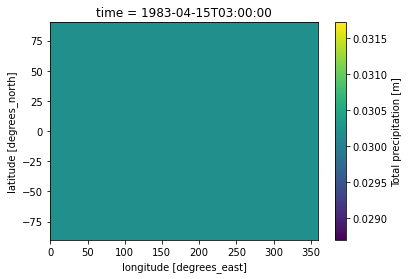

In [81]:
data_rolled.sel(time='1983-04-15T03:00:00.000000000').plot()

In [72]:
da_resampled = data_rolled[:-1].resample(time='1D', closed='right').sum(dim='time')
da_resampled

<xarray.DataArray 'tp' (time: 2, latitude: 721, longitude: 1440)>
dask.array<stack, shape=(2, 721, 1440), dtype=float32, chunksize=(1, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 1983-04-15 1983-04-16
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8

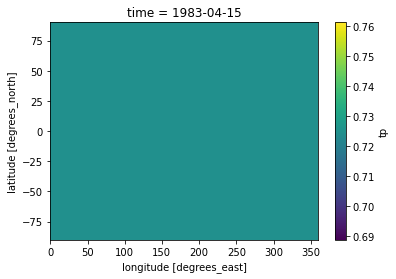

In [73]:
precip_test_load = da_resampled.sel(time=start).compute()
precip_test_load.plot()

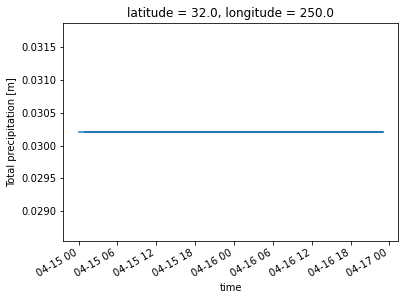

In [82]:
data_rolled.sel(latitude=32.0, longitude=250.0, method='nearest').plot()

In [25]:
precip_conus = precip_test.sel(latitude=slice(50.0,22.0), longitude=slice(235,295))
precip_conus

<xarray.DataArray 'tp' (time: 24, latitude: 113, longitude: 241)>
dask.array<getitem, shape=(24, 113, 241), dtype=float32, chunksize=(16, 113, 241), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 50.0 49.75 49.5 49.25 ... 22.5 22.25 22.0
  * longitude  (longitude) float32 235.0 235.2 235.5 235.8 ... 294.5 294.8 295.0
  * time       (time) datetime64[ns] 1979-10-27 ... 1979-10-27T23:00:00
Attributes:
    long_name:  Total precipitation
    units:      m

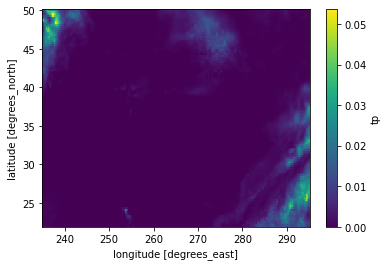

In [26]:
precip_conus.sum(dim='time').plot()

In [29]:
var_names = ['precip_total']

In [10]:
ds_scattered = client.scatter(ds)
JOBS = [(ds_scattered, var, 'v1.1', days_list[i], days_list[i+1]) for var in var_names for i in np.arange(0, len(days_list[:-1]))]

In [50]:
ds_scattered = client.scatter(ds)
JOBS = [(ds_scattered, var, 'v1.2', days_list_1983[i], days_list_1983[i+1]) for var in var_names for i in np.arange(0, len(days_list_1983[:-1]))]



In [31]:
len(JOBS)

366

In [38]:
JOBS[200]

(<Future: finished, type: xarray.Dataset, key: Dataset-ae3ad1044a5d289332e5629015a1837c>,
 'precip_total',
 'v1.1',
 Timestamp('1983-07-20 00:00:00', freq='D'),
 Timestamp('1983-07-21 00:00:00', freq='D'))

In [40]:
%%time
test_future = client.submit(create_daily_files, JOBS[100])
dd.progress(test_future)

CPU times: user 12.7 ms, sys: 2.35 ms, total: 15.1 ms
Wall time: 11.5 ms


VBox()

In [51]:
%%time
futures1 = client.map(create_daily_files, JOBS)
dd.progress(futures1)

CPU times: user 80.3 ms, sys: 9.12 ms, total: 89.4 ms
Wall time: 81.2 ms


VBox()

In [37]:
%%time
futures2 = client.map(create_daily_files, JOBS[1000:5000])
dd.progress(futures2)

CPU times: user 532 ms, sys: 47.7 ms, total: 580 ms
Wall time: 556 ms


VBox()

In [38]:
%%time
futures3 = client.map(create_daily_files, JOBS[5000:10000])
dd.progress(futures3)

CPU times: user 491 ms, sys: 28.7 ms, total: 519 ms
Wall time: 517 ms


VBox()

client.restart() -- can be used here

In [34]:
%%time
futures4 = client.map(create_daily_files, JOBS[10000:])
dd.progress(futures4)

CPU times: user 433 ms, sys: 9.08 ms, total: 442 ms
Wall time: 438 ms


VBox()

Test daily files -- end in 2018

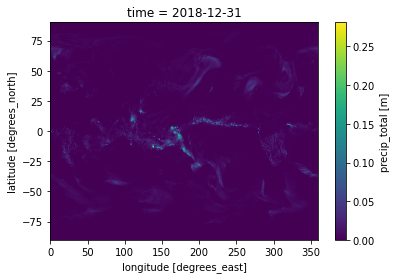

In [39]:
test = xr.open_mfdataset('/gcs/impactlab-data/climate/source_data/ERA-5/day/precip_total/v1.1/intermediate/2018/precip_total_2018-12-31.nc')
test['precip_total'].plot()

In [45]:
def create_yearly_files(spec):
    '''
    creates yearly files of daily data for the specified variable and year 
    '''
    
    var_name, year = spec
    
    source_direc = ('/gcs/impactlab-data/climate/source_data/ERA-5/day/{variable}/{version}/intermediate/{year}/*').format(variable=var_name, 
                                                                                                                         version=version,
                                                                                                                         year=year)
                                                                                                           
        
    with xr.open_mfdataset(source_direc, concat_dim='time', combine='nested') as ds_concat:

        out_filename = ('/gcs/impactlab-data/climate/source_data/ERA-5/day/'
                            '{variable}/{version}/{variable}_daily_{year}-{year}.nc').format(variable=var_name,
                                                                                             version=version,
                                                                                             year=year)

        # file attributes 
        source = ('yearly files of ERA-5 daily data created from %s' %source_direc)
        method = ('concatenate daily files for each year')

        attrsdt = {
                    'version': version,
                    'author': 'Meredith Fish',
                    'contact': 'meredith.fish@rutgers.edu',
                    'project': ('historical-climate-data-diagnostics'),
                    'source': source,
                    'created': datetime.now().strftime('%Y-%m-%d'),
                    'method': method,
                    'units': units[var_name]}

        ds_concat.attrs.update(attrsdt)
        ds_chunked = ds_concat.chunk({'time': len(ds_concat.time), 'latitude': len(ds_concat.latitude), 'longitude': len(ds_concat.longitude)})

        ds_computed = ds_chunked.compute()
        ds_computed.to_netcdf(out_filename, mode='w')

    print("wrote %s" %out_filename)

In [46]:
years = np.arange(1983, 1984) #1979

In [47]:
var_name = 'precip_total'
for year in years: 
    spec = (var_name, year)
    create_yearly_files(spec)

PermissionError: [Errno 13] Permission denied: b'/gcs/impactlab-data/climate/source_data/ERA-5/day/precip_total/v1.1/precip_total_daily_1983-1983.nc'